In [1]:
# Import statements
import torch                                                  # pytorch
from torch import nn                                          # neural network model from pytorch
from torch.nn import functional                               # functions
from torch.utils.data import DataLoader                       # load data
from torchvision import datasets                              # torchvision is to learn graphical stuff
from torchvision.transforms import ToTensor, Lambda, Compose  # 
import matplotlib.pyplot as plt                               # plotting using pyplot write plt
import matplotlib.image as mpimg                              # plotting using library to better plot pics, write mpimg
import pandas as pd                                           # tables to save/organise data

In [2]:
# Loading CIFAR10 training and test data
# Image dataset for classification
# 10 mutual exclusive classes (animals and vehicles)
# image size 32x32, 3 color dimensions (RGB-like)

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


# Different CIFAR10 classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 64                                                  # How many data points at once to train

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)                  # batch size, no of channels, height, width
    print("Shape of y: ", y.shape, y.dtype)                      # will be transferred to sparse vector later 
    break
    

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


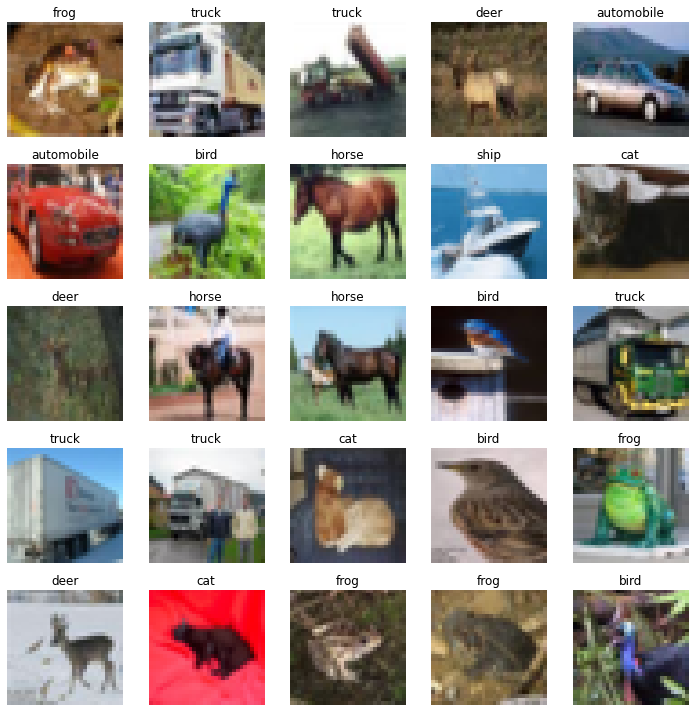

In [4]:
# Plot some of the image data (would be more elegant with tensorboard)

i, (inputs, targets) = next(enumerate(train_dataloader))
# plot some images
fig = plt.figure(figsize=(10,10))
for i in range(25):
    
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot image (needs reordering of dimension)
    plt.imshow(inputs[i].permute(1,2,0))
    # no need for axis for pictures
    plt.axis('off')
    # print class as subplot title
    plt.title(classes[targets[i].item()])

# show the figure
plt.tight_layout()
plt.show()

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define a simple CNN 
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolutional layer (number of in channels = 3 (number of color dims (RGB)),
        #                            number of out channels = 6,
        #                            kernel size = 5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Maximum pooling layer (kernelsize=2) after each conv layer # make nn smaller again
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer (number of in channels = 6 
        #                                (number of output channels from first layer),
        #                            number of out channels = 16,
        #                            kernel size = 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Dense layers
        # 16 channels * kernel size * kernel size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # number of output neurons = number of classes

    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))                 # relu is activation function. 0 for <0, more for >0
        x = self.pool(functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch # from multidimensional to vector, for dense layers
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) # function: Stochastic gradient descent

In [7]:
# Train function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss.append(float(loss))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress every 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return float(sum(train_loss)/len(train_loss))

In [8]:
# Test function
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return float(test_loss), float(correct)

In [9]:
epochs = 50                                                         # how many times running through the whole data set
history = pd.DataFrame()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # do a training iteration and save (average) loss
    history.loc[t, "train_loss"]  = train(train_dataloader, model, loss_fn, optimizer)
    
    # do test iteration and save loss and accuracy
    history.loc[t, "test_loss"], history.loc[t, "test_acc"] = test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305064  [    0/50000]
loss: 2.304123  [ 6400/50000]
loss: 2.302827  [12800/50000]
loss: 2.307302  [19200/50000]
loss: 2.298128  [25600/50000]
loss: 2.306471  [32000/50000]
loss: 2.298558  [38400/50000]
loss: 2.294106  [44800/50000]
Test Error: 
 Accuracy: 10.8%, Avg loss: 0.036067 

Epoch 2
-------------------------------
loss: 2.298546  [    0/50000]
loss: 2.297329  [ 6400/50000]
loss: 2.288819  [12800/50000]
loss: 2.292242  [19200/50000]
loss: 2.279201  [25600/50000]
loss: 2.262921  [32000/50000]
loss: 2.256177  [38400/50000]
loss: 2.180777  [44800/50000]
Test Error: 
 Accuracy: 20.6%, Avg loss: 0.033526 

Epoch 3
-------------------------------
loss: 2.194970  [    0/50000]
loss: 2.096984  [ 6400/50000]
loss: 1.952872  [12800/50000]
loss: 2.094364  [19200/50000]
loss: 2.142678  [25600/50000]
loss: 2.027424  [32000/50000]
loss: 2.157734  [38400/50000]
loss: 1.929413  [44800/50000]
Test Error: 
 Accuracy: 26.5%, Avg loss: 0.031045 

Epoc

loss: 1.237911  [38400/50000]
loss: 1.177850  [44800/50000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.019184 

Epoch 26
-------------------------------
loss: 1.073345  [    0/50000]
loss: 1.271407  [ 6400/50000]
loss: 0.903626  [12800/50000]
loss: 1.179658  [19200/50000]
loss: 1.103129  [25600/50000]
loss: 1.457725  [32000/50000]
loss: 1.210055  [38400/50000]
loss: 1.160251  [44800/50000]
Test Error: 
 Accuracy: 57.3%, Avg loss: 0.019050 

Epoch 27
-------------------------------
loss: 1.055488  [    0/50000]
loss: 1.254953  [ 6400/50000]
loss: 0.894993  [12800/50000]
loss: 1.177795  [19200/50000]
loss: 1.098541  [25600/50000]
loss: 1.422302  [32000/50000]
loss: 1.184186  [38400/50000]
loss: 1.144279  [44800/50000]
Test Error: 
 Accuracy: 57.5%, Avg loss: 0.018946 

Epoch 28
-------------------------------
loss: 1.039300  [    0/50000]
loss: 1.233429  [ 6400/50000]
loss: 0.888604  [12800/50000]
loss: 1.168200  [19200/50000]
loss: 1.077389  [25600/50000]
loss: 1.406631  [32000/50000]
l

loss: 0.639966  [12800/50000]
loss: 0.838240  [19200/50000]
loss: 0.768839  [25600/50000]
loss: 0.946301  [32000/50000]
loss: 0.881941  [38400/50000]
loss: 0.949850  [44800/50000]
Test Error: 
 Accuracy: 61.7%, Avg loss: 0.018422 

Done!


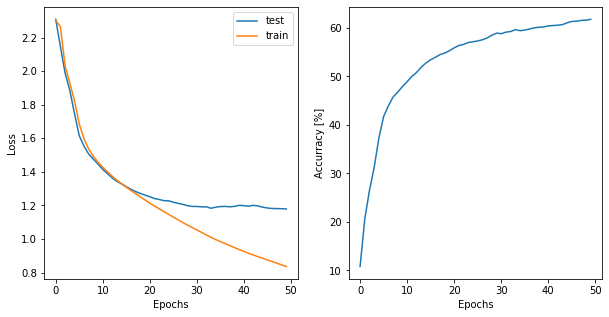

In [10]:
# Function for plotting training progress
def plot_training(data):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(data.index, data["test_loss"]*batch_size, label="test")
    ax[0].plot(data.index, data["train_loss"], label="train")

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    ax[1].plot(data.index, data["test_acc"]*100)
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accurracy [%]")

    plt.show()

# Plot training progress
plot_training(history)

In [11]:
# Save trained model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
# Load model
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: "ship", Actual: "ship"


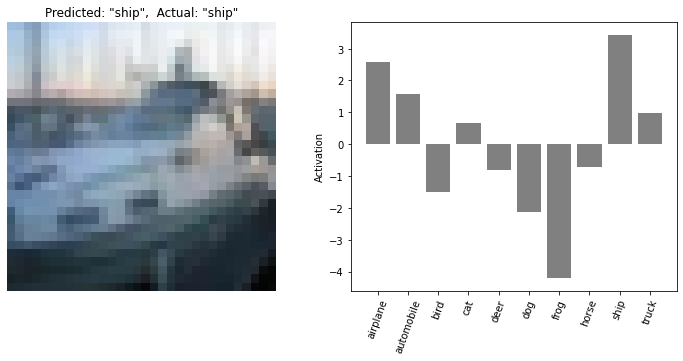

In [13]:
# Make evaluation
model.eval()
no = 2
x, y = test_data[no][0], test_data[no][1]
with torch.no_grad():
    pred = model(x.unsqueeze_(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    # plot image (needs reordering of dimension)
    ax[0].imshow(test_data[no][0].permute(1,2,0))
    # no need for axis for pictures
    ax[0].axis('off')
    # print class as subplot title
    ax[0].set_title(f'Predicted: "{predicted}",  Actual: "{actual}"')

    # Print values per category
    ax[1].bar(classes, pred[0].tolist(), color="grey")
    ax[1].set_ylabel("Activation")
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )
    plt.tight_layout()
    plt.show()